In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics
from sklearn.decomposition import PCA
from tqdm import tqdm

from src.reasoner_mod import *
from src.simplefact import *
from src.simplefact.syntax import *
from src.reasoner import *
from src.generate import *
from src.utils import *
from src.vis import *

seed = 2022

In [3]:
onto_paths = 'african-wildlife.ofn exchangemodel-noimport.ofn stuff-noimport.ofn swo-noimport.ofn ontodt-noimport.ofn pizza.ofn'.split()
onto_names = 'wildlife demacare stuff swo ontodt pizza'.split()
ontos = []
facts = []
for path in onto_paths:
    onto = load_ofn('local/out/dataset/' + path, silent=True)
    fact = Reasoner.from_onto(onto, timeout=None)
    facts.append(fact)
    ontos.append(onto)
    print(path, '\t', onto)

african-wildlife.ofn 	 <Onto 30 concepts, 5 roles, 49 axioms>
exchangemodel-noimport.ofn 	 <Onto 260 concepts, 53 roles, 369 axioms>
stuff-noimport.ofn 	 <Onto 192 concepts, 46 roles, 314 axioms>


FaCT++.Kernel: Reasoner for the SROIQ(D) Description Logic, 64-bit
Copyright (C) Dmitry Tsarkov, 2002-2017. Version 1.7.0-SNAPSHOT (01 January 2017)


swo-noimport.ofn 	 <Onto 4067 concepts, 39 roles, 7140 axioms>
ontodt-noimport.ofn 	 <Onto 405 concepts, 8 roles, 921 axioms>
pizza.ofn 	 <Onto 99 concepts, 4 roles, 287 axioms>


In [7]:
def make_dataset(onto, fact, n_queries=32_000):
    rng = np.random.default_rng(seed)
    Nc, Nr = onto.n_concepts, onto.n_roles
    gen = AxiomGenerator(rng=rng, n_concepts=Nc, n_roles=Nr, max_depth=10, p_atomic=0.95)

    queries, answers, qset = [], [], set()
    while len(queries) < n_queries:
        axiom = gen()
        axiom_core = core(axiom)
        if axiom_core in qset: continue
        answer = fact.check_axiom(axiom)
        queries.append(axiom_core); answers.append(int(answer)); qset.add(axiom_core)
        
    return queries, answers

idx_te, X_te, y_te = [], [], []
for i, (onto, fact, onto_name) in enumerate(zip(ontos, facts, onto_names)):
    X_te_onto, y_te_onto = make_dataset(onto, fact)
    idx_te += [i]*len(X_te_onto)
    print(onto_name, '- balance', np.round(np.mean(y_te_onto), 4))
    X_te += X_te_onto
    y_te += y_te_onto
    
rng = np.random.default_rng(seed)
data = idx_te, X_te, y_te = jointshuffle(rng, idx_te, X_te, y_te)

wildlife - balance 0.096
demacare - balance 0.043
stuff - balance 0.2308
swo - balance 0.2633
ontodt - balance 0.0753
pizza - balance 0.392


In [8]:
ts = timestr()

emb_size = 10
embs_params = dict(emb_size=emb_size)
head_params = dict(emb_size=emb_size, hidden_size=16)
train_params = dict(epoch_count=10, batch_size=32)


T.manual_seed(seed)
transfer_r_embs = EmbeddingLayer.from_ontos(ontos, emb_size=emb_size)
transfer_r_head = ModifiedReasonerHead(**head_params)
transfer_r_head.load_state_dict(T.load('local/out/exp/20240630T144632/reasoner.pt'))

print('----')

print('frozen reasoner head (transfer)')
T.manual_seed(seed)
transfer_log = train_mod(data, None, transfer_r_head, transfer_r_embs, freeze_reasoner=True, run_name='frozen transfer', **train_params)


----
frozen reasoner head (transfer)
train epoch 00/10 | batch 6001/6000 | loss 1.2064 | val loss 1.2064 | acc 0.6641 | f1 0.3872 | prec 0.2909 | recall 0.5786 | roc auc 0.6855 | pr auc 0.4336 | elapsed 484.95s
train epoch 01/10 | batch 6001/6000 | loss 0.5480 | val loss 0.2740 | acc 0.8974 | f1 0.7166 | prec 0.7264 | recall 0.7071 | roc auc 0.9223 | pr auc 0.7942 | elapsed 646.49s
train epoch 02/10 | batch 6001/6000 | loss 0.2370 | val loss 0.1903 | acc 0.9300 | f1 0.8025 | prec 0.8317 | recall 0.7752 | roc auc 0.9577 | pr auc 0.8787 | elapsed 620.82s
train epoch 03/10 | batch 6001/6000 | loss 0.1859 | val loss 0.1608 | acc 0.9413 | f1 0.8348 | prec 0.8629 | recall 0.8084 | roc auc 0.9695 | pr auc 0.9078 | elapsed 605.76s
train epoch 04/10 | batch 6001/6000 | loss 0.1628 | val loss 0.1447 | acc 0.9481 | f1 0.8533 | prec 0.8851 | recall 0.8238 | roc auc 0.9753 | pr auc 0.9231 | elapsed 614.26s
train epoch 05/10 | batch 6001/6000 | loss 0.1490 | val loss 0.1339 | acc 0.9529 | f1 0.8676 

In [9]:
ts = timestr()

emb_size = 10
embs_params = dict(emb_size=emb_size)
head_params = dict(emb_size=emb_size, hidden_size=16)
train_params = dict(epoch_count=10, batch_size=32)

T.manual_seed(seed)
transfer_r_orig_embs = EmbeddingLayer.from_ontos(ontos, emb_size=emb_size)
transfer_r_orig_head = ReasonerHead(**head_params)
transfer_r_orig_head.load_state_dict(T.load('local/out/exp/20220715T194304/reasoner.pt'))


print('frozen reasoner head (transfer)')
T.manual_seed(seed)
transfer_log_orig = train(data, None, transfer_r_orig_head, transfer_r_orig_embs, freeze_reasoner=True, run_name='frozen transfer original', **train_params)


frozen reasoner head (transfer)
train epoch 00/10 | batch 6001/6000 | loss 1.1830 | val loss 1.1830 | acc 0.6625 | f1 0.4367 | prec 0.3146 | recall 0.7134 | roc auc 0.7410 | pr auc 0.4635 | elapsed 126.88s
train epoch 01/10 | batch 6001/6000 | loss 0.4640 | val loss 0.2367 | acc 0.9149 | f1 0.7664 | prec 0.7715 | recall 0.7614 | roc auc 0.9365 | pr auc 0.8388 | elapsed 300.52s
train epoch 02/10 | batch 6001/6000 | loss 0.2161 | val loss 0.1836 | acc 0.9364 | f1 0.8217 | prec 0.8459 | recall 0.7988 | roc auc 0.9594 | pr auc 0.8893 | elapsed 277.93s
train epoch 03/10 | batch 6001/6000 | loss 0.1830 | val loss 0.1634 | acc 0.9435 | f1 0.8415 | prec 0.8667 | recall 0.8177 | roc auc 0.9677 | pr auc 0.9078 | elapsed 286.88s
train epoch 04/10 | batch 6001/6000 | loss 0.1668 | val loss 0.1516 | acc 0.9482 | f1 0.8542 | prec 0.8836 | recall 0.8266 | roc auc 0.9722 | pr auc 0.9187 | elapsed 291.69s
train epoch 05/10 | batch 6001/6000 | loss 0.1565 | val loss 0.1434 | acc 0.9512 | f1 0.8628 | pre

local/out/exp/20240704T200736
------
Frozen pre-trained reasoner head original
train time 2521.1852748394012
           mean     std   micro
acc      0.9589  0.0273  0.9589
prec     0.9166  0.0543  0.9084
recall   0.8350  0.1081  0.8632
f1       0.8721  0.0799  0.8852
auc_roc  0.9772  0.0162  0.9823
auc_pr   0.9302  0.0580  0.9450
------
Frozen pre-trained reasoner head
train time 4883.251648426056
           mean     std   micro
acc      0.9626  0.0270  0.9626
prec     0.9214  0.0586  0.9157
recall   0.8486  0.1101  0.8769
f1       0.8818  0.0829  0.8959
auc_roc  0.9811  0.0153  0.9862
auc_pr   0.9377  0.0576  0.9541


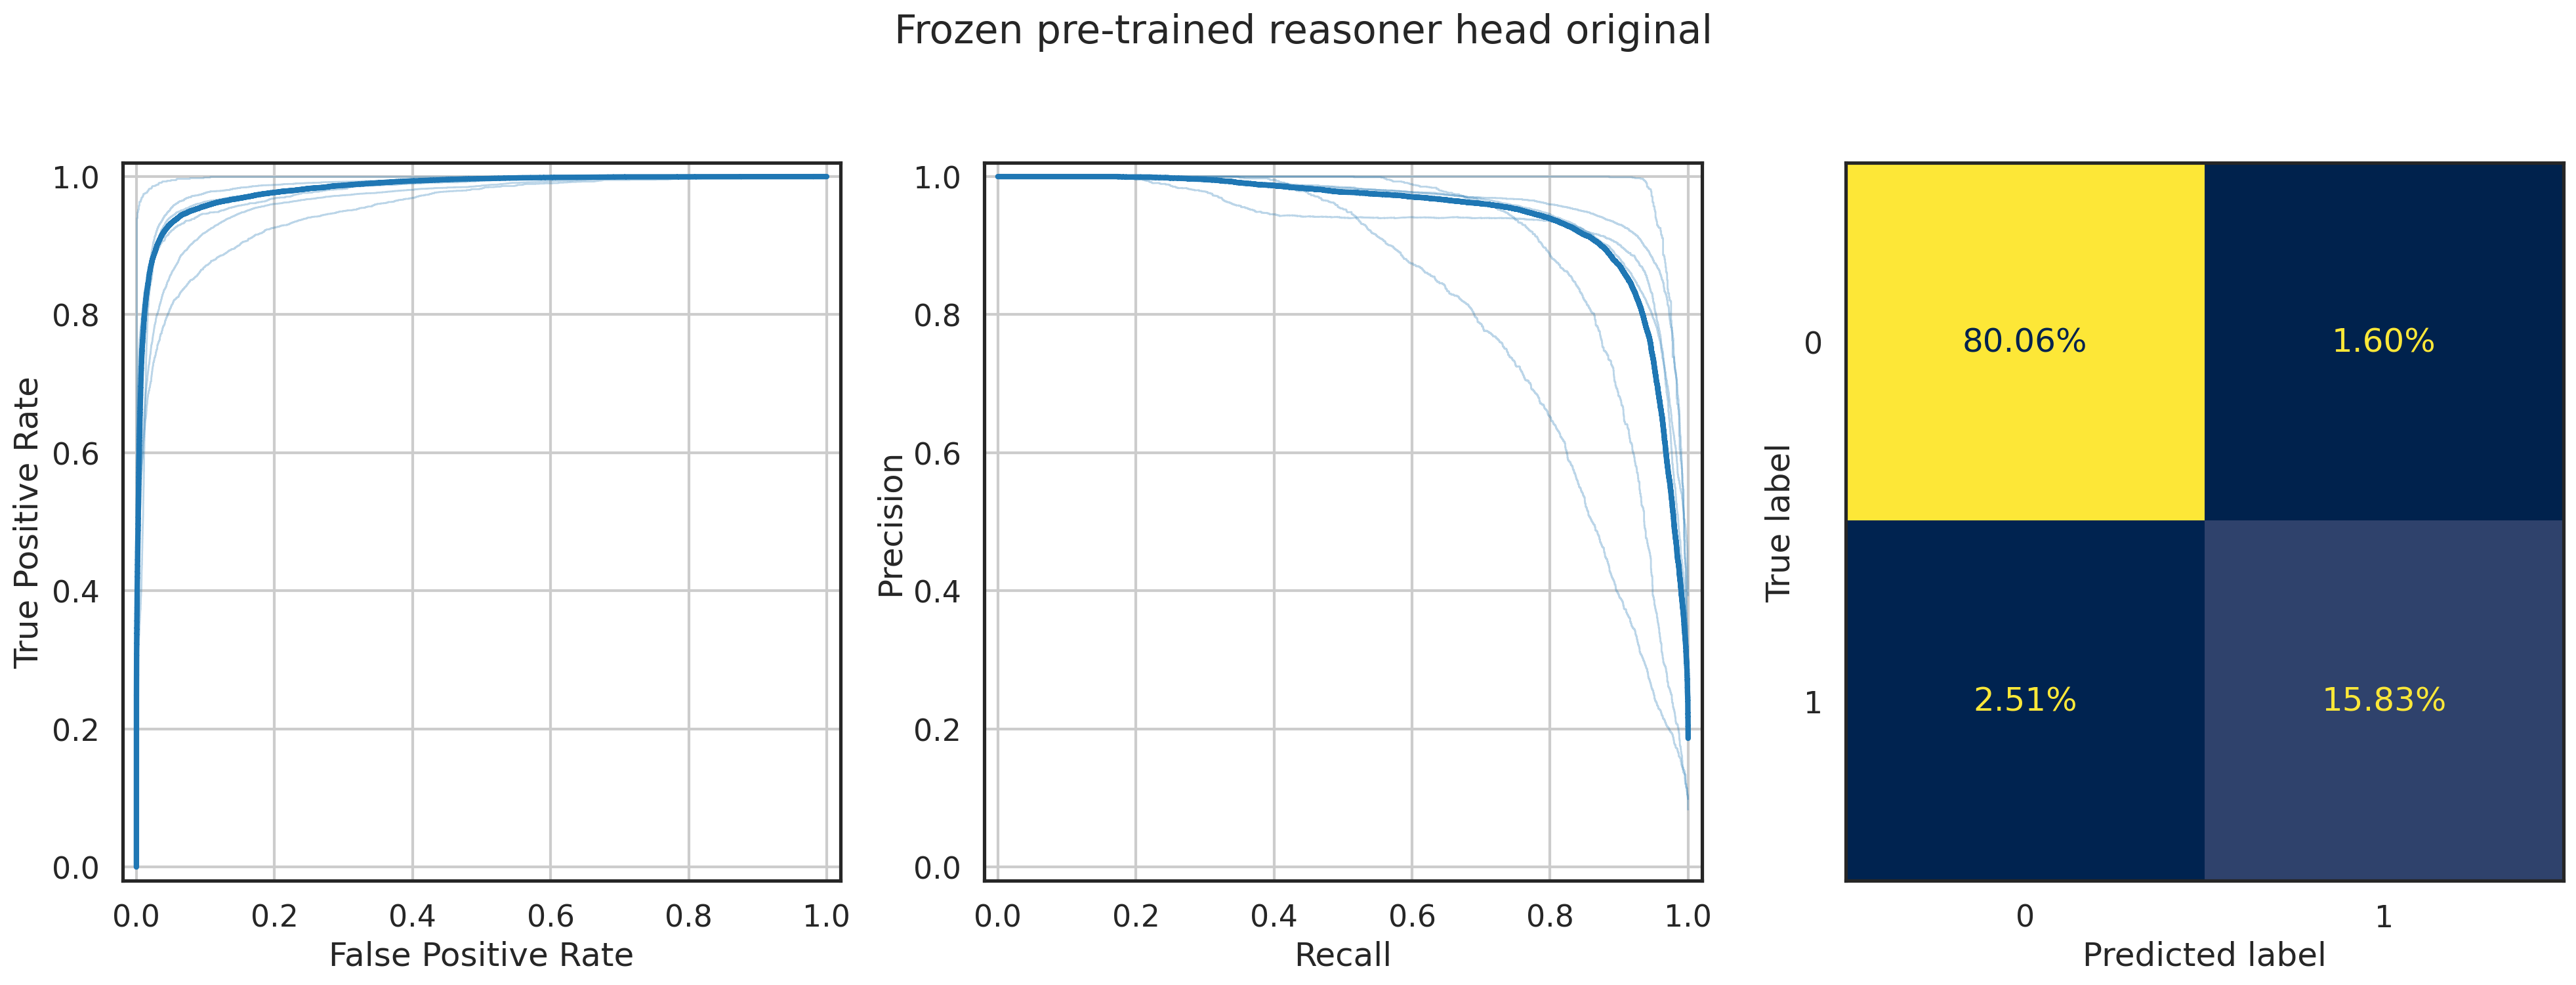

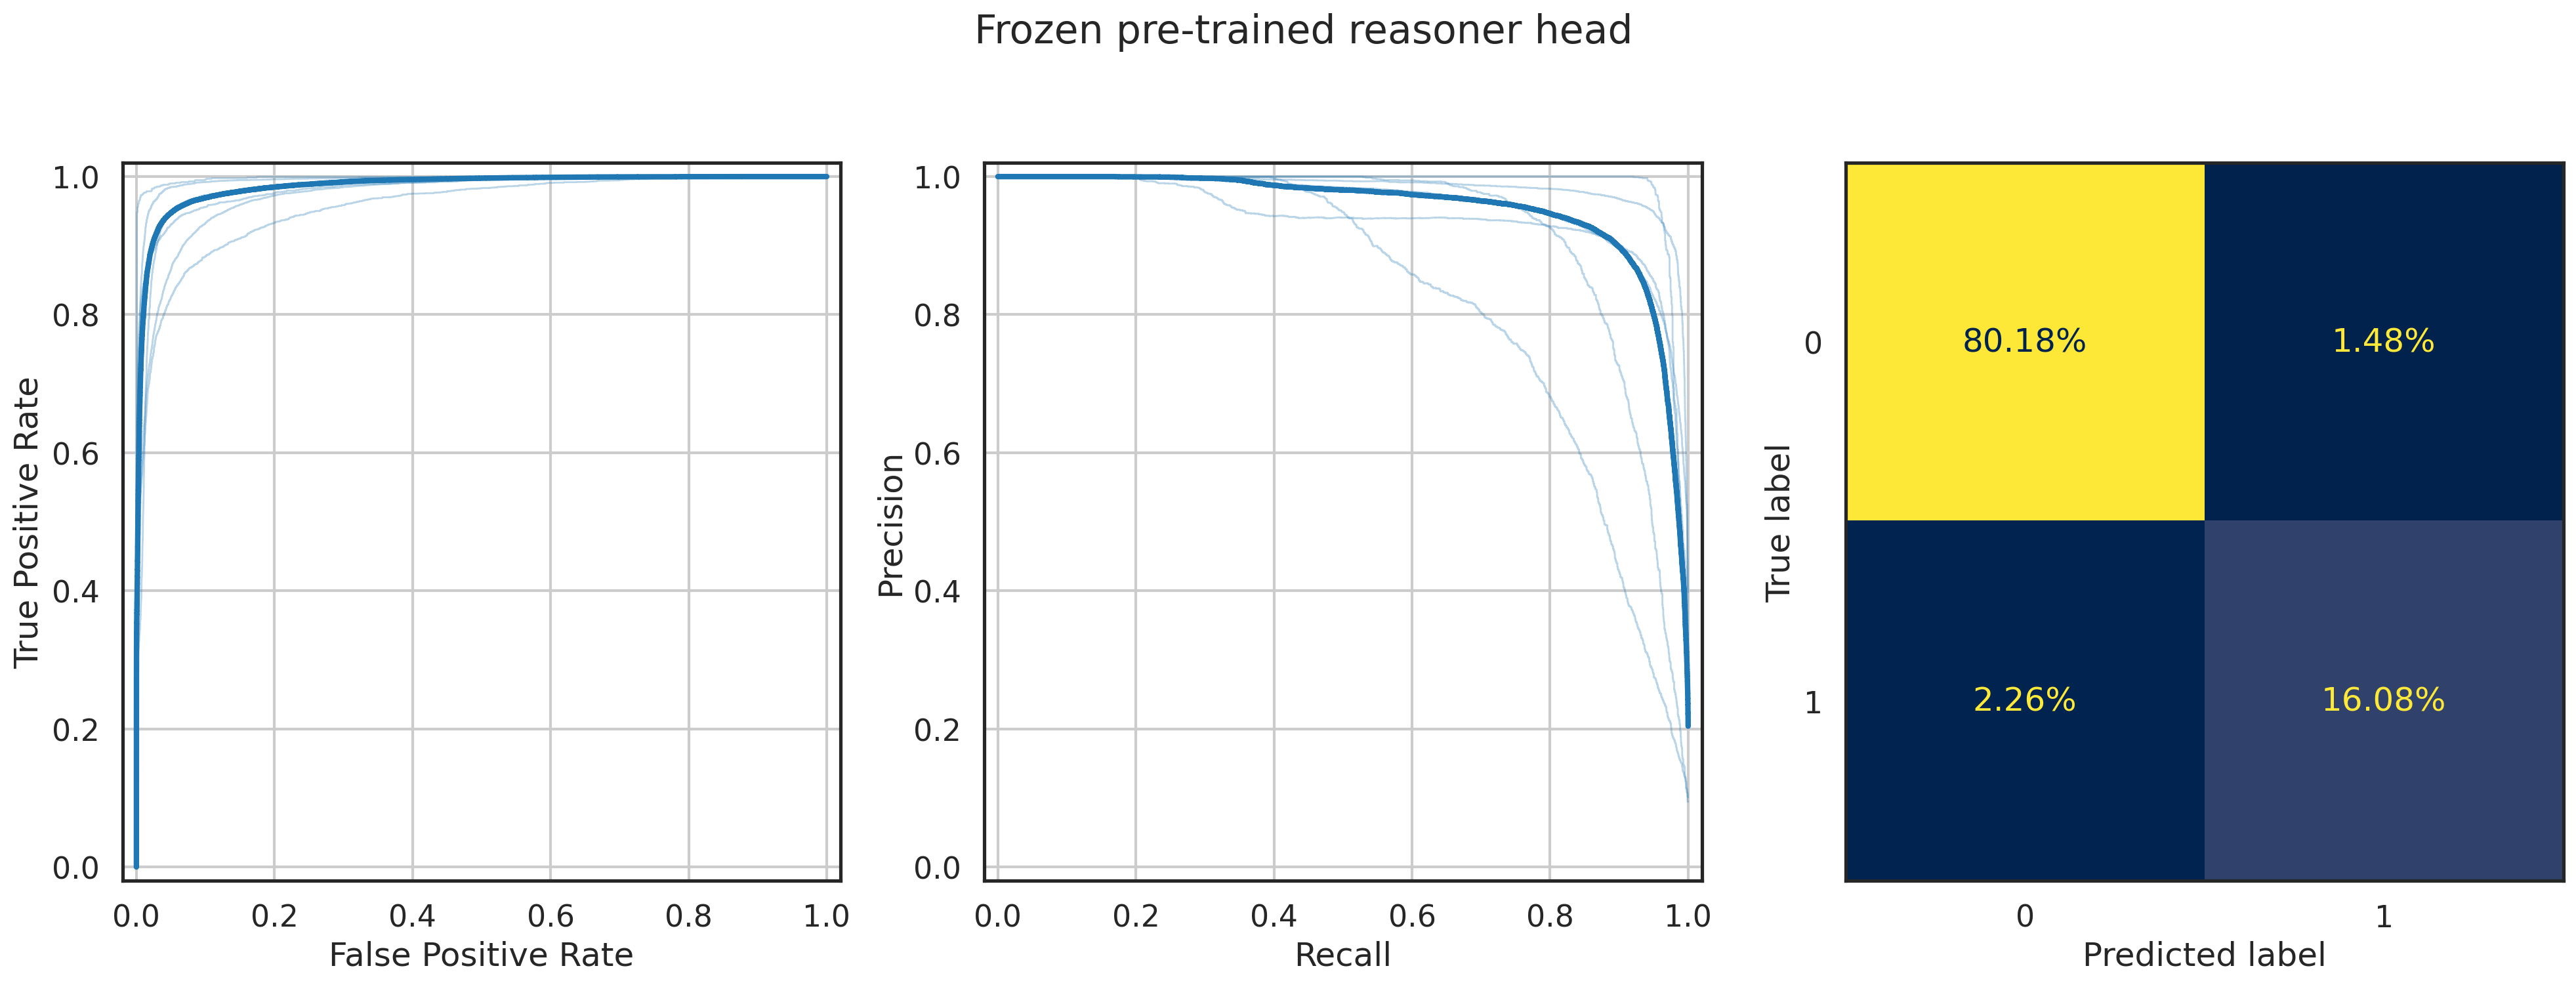

In [10]:
titles = 'Expected', 'Frozen pre-trained reasoner head original', 'Frozen pre-trained reasoner head'
logs = transfer_log_orig, transfer_log
heads = transfer_r_orig_head, transfer_r_head
embeddings = transfer_r_orig_embs, transfer_r_embs

base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

for head, embs, log, title in zip(heads, embeddings, logs, titles[1:]):
    print('------')
    with T.no_grad():
        head.eval()
        if title == 'Frozen pre-trained reasoner head original':
            _, _, Y_te = eval_batch(head, embs, X_te, y_te, idx_te)
        else:
            _, _, Y_te = eval_batch_mod(head, embs, X_te, y_te, idx_te)

    print(title)
    
    history_tr = pd.DataFrame(log.history_tr)
    test_history_by_onto = pd.DataFrame(log.history_vl_by_onto)
    test_history = pd.DataFrame(log.history_vl)
    test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te=Y_te))
    test_history.to_csv(base+f'/{title} test.csv', index=False)
    test_history_by_onto.to_csv(base+f'/{title} test by onto.csv', index=False)
    test_results.to_csv(base+f'/{title} test clas.csv', index=False)

    print('train time', history_tr.groupby('epoch').max().elapsed.sum())
    print(report(ontos, y_te, Y_te, idx_te).round(4))
    plt.suptitle(title)

In [11]:
for head, embs, log, title in zip(heads, embeddings, logs, titles[1:]):
    df = pd.DataFrame(log.history_vl_by_onto)
    df = df[df.epoch == df.epoch.max()].drop(columns=['epoch', 'run', 'elapsed'])
    df.onto = df.onto.map(onto_names.__getitem__)
    print('-'*10)
    print(title)
    #print(df.agg(['mean', 'std']).round(4).T)
    print(df.round(4))

----------
Frozen pre-trained reasoner head original
       acc      f1    prec  recall  roc_auc  pr_auc      onto
60  0.9541  0.7320  0.8315  0.6539   0.9522  0.8239  wildlife
61  0.9968  0.9608  0.9977  0.9265   0.9990  0.9871  demacare
62  0.9528  0.8959  0.9128  0.8797   0.9793  0.9369     stuff
63  0.9571  0.9179  0.9256  0.9103   0.9860  0.9662       swo
64  0.9775  0.8344  0.9365  0.7524   0.9802  0.9124    ontodt
65  0.9154  0.8916  0.8959  0.8874   0.9663  0.9550     pizza
----------
Frozen pre-trained reasoner head
       acc      f1    prec  recall  roc_auc  pr_auc      onto
60  0.9542  0.7353  0.8259  0.6627   0.9562  0.8311  wildlife
61  0.9971  0.9647  0.9977  0.9338   0.9986  0.9864  demacare
62  0.9532  0.8979  0.9057  0.8902   0.9821  0.9396     stuff
63  0.9731  0.9487  0.9533  0.9442   0.9940  0.9845       swo
64  0.9793  0.8485  0.9446  0.7702   0.9835  0.9245    ontodt
65  0.9189  0.8959  0.9012  0.8907   0.9725  0.9601     pizza
